# `016` Transformers

Requirements: 014 Attention and dropout, 015 Residual connections

Attention mechanisms were proposed as a way to make the RNN inputs contain information about other terms in the sequence. This way, every sequence element can be contextualized properly with the information from other tokens. However, an architecture called transformer proposed by [Vaswani et al., 2017](ttps://arxiv.org/pdf/2002.04745v1.pdf) took the world by surprise.

Basically, he removed the RNN layers and used just a bunch of linear layers, attention mechanisms, residual connections and normalization. Applied in the context of German to English translation, the architecture achieved better quality (BLEU score) than any previous model. Furthermore, applying it over general text corpuses created a level of generalization pretty impressive and scalable with model size.

In this notebook I will define a transformer block, build a model with many of them, and train it over the Spanish novels corpus also used for the Embeddings notebook.

In [1]:
from matplotlib import pyplot as plt
from re import sub
from time import time
import torch

device = torch.device('cuda' if torch.backends.cudnn.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


In [2]:
tokens = ' !(),-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz¡¿ÁÉÍÑÓÚÜáéíñóúü'
t2i = {c: i for i, c in enumerate(tokens)}
i2t = {i: c for i, c in enumerate(tokens)}

with open('custom-data/spanish-novels.txt', encoding='utf-8') as fp:
	data = fp.read()

data = sub(r'\s*\n\s*', ' ', data)
data = [t2i[c] for c in data if c in tokens]
data = torch.tensor(data, dtype=torch.long).to(device)
print(f'dataset size: {data.shape[0]} (that\'s like {100 * data.shape[0] / 20000000000000:.6f}% of GPT-4\'s training data)')

dataset size: 19263904 (that's like 0.000096% of GPT-4's training data)


In [3]:
def get_batch(split='train', train_size=.8, size=64, context_size=256):
	limit = int(data.shape[0] * train_size) if split == 'train' else data.shape[0]
	starts = torch.randint(0, limit - context_size, (size,))
	x = torch.stack([data[s:s+context_size] for s in starts])
	y = torch.stack([data[s+1:s+context_size+1] for s in starts])
	return x, y

x, y = get_batch(size=4)
print(x.shape, y.shape)
print(''.join(i2t[j.item()] for j in x[0]))
print(''.join(i2t[j.item()] for j in y[0]))

torch.Size([4, 256]) torch.Size([4, 256])
á los españoles; amaba á D. Juan, porque no le conocía y porque los partidarios de éste, astutamente, le habían hecho entender que era bueno y generoso y amigo del bien de España. Con tales sentimientos y con tal Rey no era difícil que se preparase la vuel
 los españoles; amaba á D. Juan, porque no le conocía y porque los partidarios de éste, astutamente, le habían hecho entender que era bueno y generoso y amigo del bien de España. Con tales sentimientos y con tal Rey no era difícil que se preparase la vuelt


Now let's define the trasnformer block. This block can be understood like an individual step in the thinking process: first you pay attention to something specific (attention layer), and then you extract conclusions about it (linear layer).

To prevent vanishing/exploding gradients from happening, normalizations are added in between both. In the original transfomers paper batch normalization was used. However, batchnorm is annoying in that the elements in the batch have interdependencies when computing the average and standard deviation, so in practice approaches like LayerNorm or RMSNorm are used. RMSNorm stands for Root Mean Squared normalization, and it's as simple as squaring all the weights, adding them together, and dividng all weights by the root square of that number, so that the "vector" of weights becomes unitary (norm = 1).

Additionally, residual connections are added all over the model. This way, transformers can be thought as a main gradient highway that is the original value, and at each step we fork from that highway, do something, and merge back in.

In [4]:
class TransformerBlock(torch.nn.Module):
	def __init__(self, context_size=128, channels=256, num_heads=8, dropout=.1):
		super().__init__()
		self.attn = torch.nn.MultiheadAttention(channels, num_heads, dropout, batch_first=True)
		mask = torch.tril(torch.ones(context_size, context_size, device=device)) == 0
		self.register_buffer('causal_mask', mask)
		self.norm1 = torch.nn.LayerNorm(channels)
		self.ff = torch.nn.Sequential(
			torch.nn.Linear(channels, 4 * channels),
			torch.nn.ReLU(),
			torch.nn.Linear(4 * channels, channels)
		)
		self.dropout = torch.nn.Dropout(dropout)
		self.norm2 = torch.nn.LayerNorm(channels)

	def forward(self, x):
		x = self.norm1(x)
		x = x + self.attn(x, x, x, attn_mask=self.causal_mask)[0]
		x = self.norm2(x)
		x = x + self.ff(x)
		x = self.dropout(x)
		return x

Now let's build the language model out of it. We'll basically just embed all tokens, pass them through a bunch of transformer layers, and then use a linear layer to output the logits of weights.

In [5]:
class LanguageModel(torch.nn.Module):
	def __init__(self, vocab_size, context_size=128, hidden_size=256, num_blocks=8, num_heads=8, dropout=.1):
		super().__init__()
		self.tok_emb = torch.nn.Embedding(vocab_size, hidden_size)
		self.pos_emb = torch.nn.Embedding(context_size, hidden_size)
		self.blocks = torch.nn.Sequential(*[
			TransformerBlock(context_size, hidden_size, num_heads, dropout)
			for _ in range(num_blocks)
		])
		self.out = torch.nn.Linear(hidden_size, vocab_size)

	def forward(self, x):
		x = self.tok_emb(x) + self.pos_emb(torch.arange(x.size(-1), device=x.device))
		x = self.blocks(x)
		x = self.out(x)
		return x

model = LanguageModel(len(tokens)).to(device)
print(f'Model has {sum(p.numel() for p in model.parameters())} parameters')

Model has 6396505 parameters


Let's now train our network to see how well it learns. One problem with these pretty deep neural networks with so many attention layers is that they need much lower learning rates, and hence many more training steps. This is one of the main problems that make training unfeasible in domestic computers in reasonable times anymore. For instance, training a GPT-2 level network requires about 16 hours in a cluster of 8 A100 GPUs as of 2024, which means spending around $200.

In [6]:
stats_each = 100
update_each = 10  # gradient accumulation: poor's man batch size increase
train_losses, test_losses, lrs = [], {}, []

def train(model, epochs=20000, warmup_epochs=1000, batch_size=32, context_size=128, max_lr=4e-4, min_lr=1e-5):
	model.train()
	optimizer = torch.optim.AdamW(model.parameters(), betas=(.9, .95))
	start = time()
	loss = 0
	for e in range(epochs):
		# compute loss
		x_batch, y_batch = get_batch(size=batch_size, context_size=context_size)
		logits = model(x_batch).view(-1, len(tokens))
		loss += torch.nn.functional.cross_entropy(logits.view(-1, len(tokens)), y_batch.view(-1))
		if e % update_each == 0:
			# update lr
			if e < warmup_epochs:
				lr = min_lr + (max_lr - min_lr) * (e / warmup_epochs)
			else:
				lr = min_lr + (max_lr - min_lr) * ((epochs - e) / (epochs - warmup_epochs))
			optimizer.param_groups[0]['lr'] = lr
			lrs.append(lr)
			# update weights
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
			train_losses.append(loss.item())
			loss = 0
		# stats
		if e % stats_each == 0 or e == 50:
			remaining = (time() - start) * (epochs - e - 1) / (e + 1)
			remaining = f'{remaining//3600:02.0f}:{remaining%3600//60:02.0f}:{remaining%60:02.0f}'
			x_batch, y_batch = get_batch('test', size=batch_size, context_size=context_size)
			logits = model(x_batch).view(-1, len(tokens))
			test_loss = torch.nn.functional.cross_entropy(logits.view(-1, len(tokens)), y_batch.view(-1))
			test_losses[e] = test_loss.item()
			print(f'epoch {e:4d} | lr {lr:.6f} | train loss {train_losses[-1] / update_each:6f} | test loss {test_loss:6f} | remaining {remaining}')

train(model)

epoch    0 | lr 0.000010 | train loss 0.480617 | test loss 4.744027 | remaining 02:23:06
epoch   50 | lr 0.000029 | train loss 4.356249 | test loss 4.219219 | remaining 00:43:10
epoch  100 | lr 0.000049 | train loss 3.690343 | test loss 3.615515 | remaining 00:41:17
epoch  200 | lr 0.000088 | train loss 3.161401 | test loss 3.128859 | remaining 00:40:21
epoch  300 | lr 0.000127 | train loss 3.019750 | test loss 3.043921 | remaining 00:39:45
epoch  400 | lr 0.000166 | train loss 2.833731 | test loss 2.765153 | remaining 00:39:23
epoch  500 | lr 0.000205 | train loss 2.686992 | test loss 2.704226 | remaining 00:39:20
epoch  600 | lr 0.000244 | train loss 2.574919 | test loss 2.593363 | remaining 00:39:17
epoch  700 | lr 0.000283 | train loss 2.517020 | test loss 2.545487 | remaining 00:39:05
epoch  800 | lr 0.000322 | train loss 2.495296 | test loss 2.430709 | remaining 00:38:55
epoch  900 | lr 0.000361 | train loss 2.446717 | test loss 2.440305 | remaining 00:38:40
epoch 1000 | lr 0.000

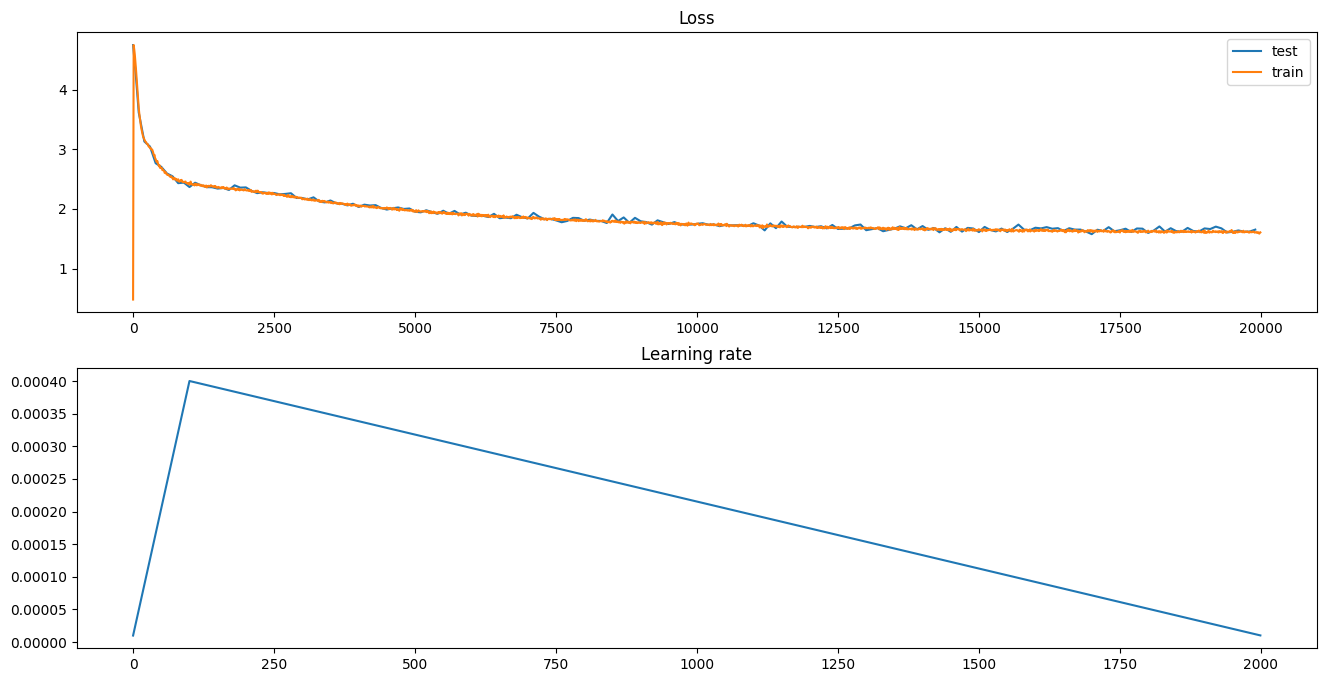

In [10]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.title('Loss')
plt.plot(*zip(*test_losses.items()), label='test')
plt.plot(range(0, len(train_losses) * update_each, update_each), [t / update_each for t in train_losses], label='train')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(lrs, label='learning rate')
plt.title('Learning rate');

In [8]:
def complete(model, text, amount):
	tokens = [t2i[t] for t in text]
	for _ in range(amount):
		logits = model(torch.tensor(tokens[-128:], device=device))
		probs = logits[-1].softmax(0)
		tokens.append(torch.multinomial(probs, 1).item())
	return ''.join(i2t[t] for t in tokens)

text = 'Esto es una prueba para ver qué tal funciona este método y si es posible completar de una forma más o menos correcta el texto que aquí'
complete(model, text, 1000)

'Esto es una prueba para ver qué tal funciona este método y si es posible completar de una forma más o menos correcta el texto que aquí en te vado. Mejor, acomiares de no afinires, y cuadie se fortan; o inquiera esa alitor, para otra la durada de del hacer en mercia. No teodito que irante en tu lecadro; el mismo en gores estábalica de su canticia haya en conquistable Vanzancellarios al instiganciza de jámet obje, el cámpero contarmente burga la gustusfermecio. Trevan has un docéro. La priba con sentamente á que en legal dejarse sea pasarroso al que otra que la poalma cuquientesambientosa aputanas. Cambién No Repor de Ágra de nuestra tan ya libertación se otra otra pentra y á los en lacona de élbil de los sus frorcundidades de la divora. Aquéllo y D. quellas rayos. Jan anti común, represeo sí lapez de Siurano, por Vicula, elevanco, conuertose de la dos; que se la marcustra de Viscia los mundos obsentanos hulpero inslos de Cabál, de el mano!--Se suya marma, con uno del repletido   acomo 